In [46]:
import pandas as pd
import numpy as np
import matplotlib as mtlp
import matplotlib.pyplot as plt
import category_encoders as ce
from scipy import stats
from scipy.stats import chi2
from scipy.stats import pointbiserialr
from statsmodels.stats import weightstats as stests
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import gc
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import time
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import plotly.graph_objs as go
import seaborn as sbrn

data = pd.read_csv (r'C:\Users\lenovo\OneDrive\Desktop\DS dataset\bank-additional-full.csv', sep=';')
data.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


STATISTICAL DETAILS ABOUT THE NUMERIC VALUES


In [47]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


VISUALIZATION OF CATEGORICAL VALUES

In [48]:
# BAR CHART TO SHOW THE RELATIONSHIP BETWEEN EACH CATEGORICAL VALUE AND NUMBER OF CLIENTS WITH BANK DEPOSITS
def barChart(column):
    tempData = pd.DataFrame()
    tempData['No_deposit'] = data[data['y'] == 'no'][column].value_counts()
    tempData['Yes_deposit'] = data[data['y'] == 'yes'][column].value_counts()
    tempData.plot(kind='bar')
    plt.xlabel(f'{column}')
    plt.ylabel('Number of clients')
    plt.title('Distribution of {} and deposit'.format(column))
    plt.show
    

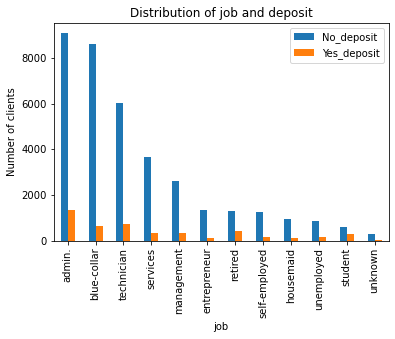

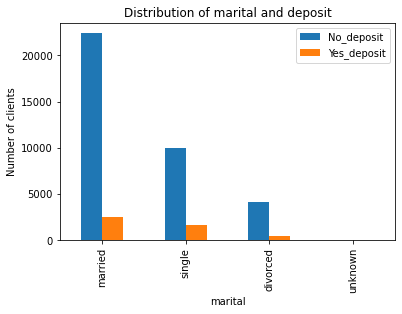

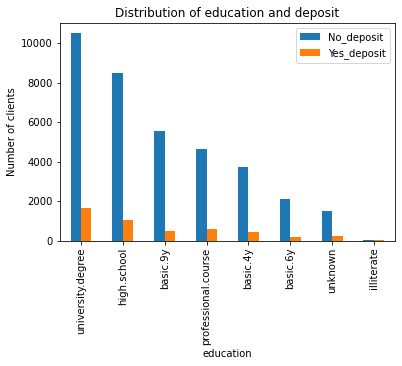

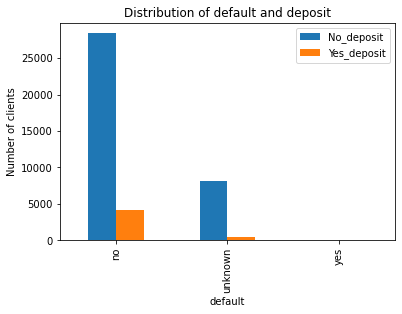

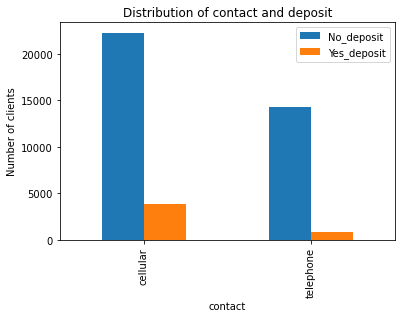

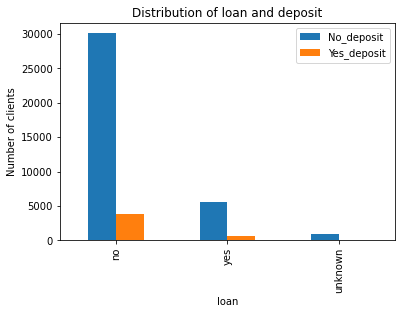

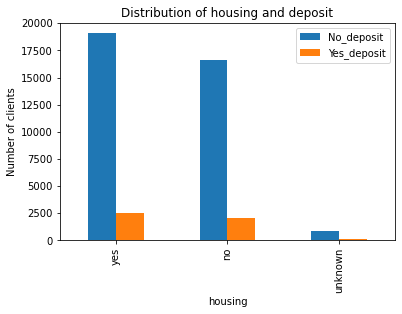

In [49]:
barChart('job')
barChart('marital')
barChart('education')
barChart('default')
barChart('contact') 
barChart('loan') 
barChart('housing')

VIZUALIZATION OF NUMERIC VALUES

In [50]:
# CORRELATION COEFFICIENT BETWEEN NUMERIC VALUES 
data.y = data.y.map({'no':0, 'yes':1}).astype('uint8')
corr = data.corr()
corr.style.background_gradient(cmap='GnBu')

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


In [51]:
# BOX PLOT DIAGRAM FOR NUMERIC VALUES
def boxPlot(column):
 plt.boxplot(column, vert = False)
 plt.show

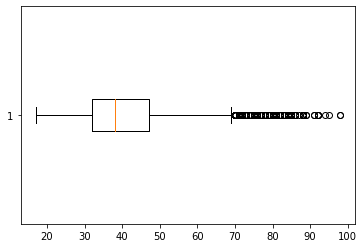

In [52]:
#BOX PLOT DIAGRAM BEFORE TREATING OUTLIERS
boxPlot(data.age)

In [53]:
# IDENTIFYING AND REPLACING OUTLIERS WITH THE MEDIAN
firstqrtl = np.percentile(data.age, 25)
thirdqrtl = np.percentile(data.age, 75)
intrqrtlrng = thirdqrtl-firstqrtl
lower_bound = firstqrtl-(1.5*intrqrtlrng)
upper_bound = thirdqrtl+(1.5*intrqrtlrng)
data.age = sorted(data.age)
median = np.median(data.age)
for j, i in enumerate(data.age):
    if (i < lower_bound or i > upper_bound):
        data.age[j] = median
print("Outliers are values less than %s and greater than %d " %(lower_bound, upper_bound))
pd.DataFrame(data.age)

Outliers are values less than 9.5 and greater than 69 


,age
0,17
1,17
2,17
3,17
4,17
...,...
41183,38
41184,38
41185,38
41186,38


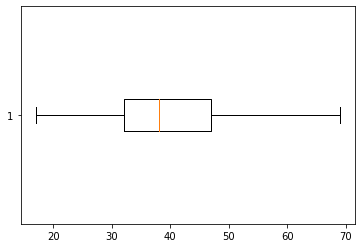

In [54]:
# BOX PLOT DIAGRAM AFTER TREATING OUTLIERS
boxPlot(data.age)

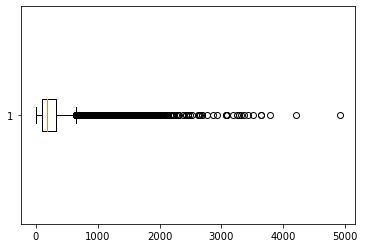

In [55]:
#BOX PLOT DIAGRAM BEFORE TREATING OUTLIERS
boxPlot(data.duration)

In [56]:
# IDENTIFYING AND REPLACING OUTLIERS WITH THE MEDIAN
firstqrtl = np.percentile(data.duration, 25)
thirdqrtl = np.percentile(data.duration, 75)
intrqrtlrng = thirdqrtl-firstqrtl
lower_bound = firstqrtl-(1.5*intrqrtlrng)
upper_bound = thirdqrtl+(1.5*intrqrtlrng)
data.duration = sorted(data.duration)
median = np.median(data.duration)
for j, i in enumerate(data.duration):
    if (i < lower_bound or i > upper_bound):
        data.duration[j] = median
print("Outliers are values less than %s and greater than %d " %(lower_bound, upper_bound))
pd.DataFrame(data.duration)

Outliers are values less than -223.5 and greater than 644 


,duration
0,0
1,0
2,0
3,0
4,1
...,...
41183,180
41184,180
41185,180
41186,180


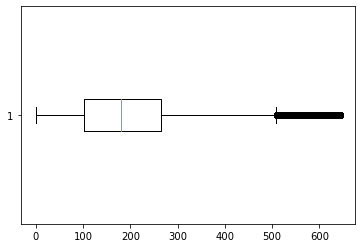

In [57]:
# BOX PLOT DIAGRAM AFTER TREATING OUTLIERS
boxPlot(data.duration)

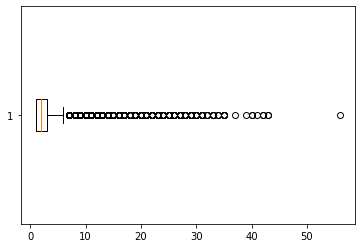

In [58]:
#BOX PLOT DIAGRAM BEFORE TREATING OUTLIERS
boxPlot(data.campaign)

In [59]:
# IDENTIFYING AND REPLACING OUTLIERS WITH THE MEDIAN
firstqrtl = np.percentile(data.campaign, 25)
thirdqrtl = np.percentile(data.campaign, 75)
intrqrtlrng = thirdqrtl-firstqrtl
lower_bound = firstqrtl-(1.5*intrqrtlrng)
upper_bound = thirdqrtl+(1.5*intrqrtlrng)
data.campaign = sorted(data.campaign)
median = np.median(data.campaign)
for j, i in enumerate(data.campaign):
    if (i < lower_bound or i > upper_bound):
        data.campaign[j] = median
print("Outliers are values less than %s and greater than %d " %(lower_bound, upper_bound))
pd.DataFrame(data.campaign)

Outliers are values less than -2.0 and greater than 6 


,campaign
0,1
1,1
2,1
3,1
4,1
...,...
41183,2
41184,2
41185,2
41186,2


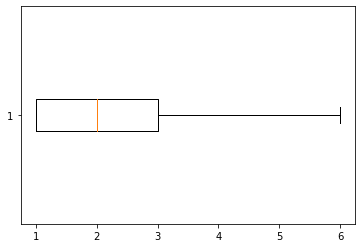

In [60]:
#BOX PLOT DIAGRAM AFTER TREATING OUTLIERS
boxPlot(data.campaign)

In [61]:
# ONLY CATEGORICAL ATTRIBUTES HAVE MISSING VALUES
percent_missing_categorical = data.__eq__('unknown').sum() * 100 / len(data)
missingValueFromData = pd.DataFrame({'column_name': data.columns,'percent_missing': percent_missing_categorical})
percent_missing_categorical[1:7]

job           0.801204
marital       0.194231
education     4.202680
default      20.872584
housing       2.403613
loan          2.403613
dtype: float64

TRANSFORMING THE DATASET

In [62]:
# REPLACING CATEGORICAL VALUES WITH BINARY 
data.contact = data.contact.map({'cellular': 1, 'telephone': 0}).astype('uint8') 
data.loan = data.loan.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.housing = data.housing.map({'yes': 1, 'unknown': 0, 'no' : 0}).astype('uint8')
data.default = data.default.map({'no': 1, 'unknown': 0, 'yes': 0}).astype('uint8')
data.pdays = data.pdays.replace(999, 0).astype('uint8')  
data.previous = data.previous.apply(lambda x: 1 if x > 0 else 0).astype('uint8') 
data.poutcome = data.poutcome.map({'nonexistent':0, 'failure':0, 'success':1}).astype('uint8') 

SCALING THE DATASET

In [63]:
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: x*0.0001 if x > 0 else x*-1)
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: -np.log(x) if x < 1 else np.log(x)).astype('uint8')

data['cons.price.idx'] = (data['cons.price.idx'] * 10).astype('uint8')

data['cons.conf.idx'] = data['cons.conf.idx'] * -1

data['nr.employed'] = np.log2(data['nr.employed']).astype('uint8')
data['cons.price.idx'] = np.log2(data['cons.price.idx']).astype('uint8')
data['cons.conf.idx'] = np.log2(data['cons.conf.idx']).astype('uint8')
data.age = np.log(data.age)

data.euribor3m = data.euribor3m.astype('uint8')
data.campaign = data.campaign.astype('uint8')

def encode(data, attribute):
    return pd.concat([data, pd.get_dummies(attribute, prefix=attribute.name)], axis=1)

data = encode(data, data.job)
data = encode(data, data.month)
data = encode(data, data.day_of_week)

data.drop(['job', 'month', 'day_of_week'], axis=1, inplace=True)

data.drop_duplicates(inplace = True)

def duration(data):
    data.loc[data['duration'] <= 102, 'duration'] = 1
    data.loc[(data['duration'] > 102) & (data['duration'] <= 180)  , 'duration'] = 2
    data.loc[(data['duration'] > 180) & (data['duration'] <= 319)  , 'duration'] = 3
    data.loc[(data['duration'] > 319) & (data['duration'] <= 645), 'duration'] = 4
    data.loc[data['duration']  > 645, 'duration'] = 5
    return data
duration(data);

y = data.y
target_encode = ce.target_encoder.TargetEncoder(cols=['marital', 'education']).fit(data, y)
numeric_dataset = target_encode.transform(data)
numeric_dataset.drop('y', axis=1, inplace=True)

In [64]:
numeric_dataset.head(10)

,age,marital,education,default,housing,loan,contact,duration,campaign,pdays,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,2.833213,0.122269,0.117697,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
1,2.833213,0.122269,0.124860,0,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
2,2.833213,0.122269,0.124860,1,1,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
3,2.833213,0.122269,0.091358,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
4,2.833213,0.122269,0.124860,1,0,1,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
5,2.890372,0.122269,0.093788,0,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
6,2.890372,0.122269,0.134335,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
7,2.890372,0.122269,0.151199,0,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
8,2.890372,0.158153,0.134335,1,1,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
9,2.890372,0.158153,0.124860,1,1,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0


In [65]:
numeric_dataset.shape

(34139, 44)

VISUALIZATION OF RELATIONSHIPS BETWEEN DIFFERENT ATTRIBUTES AND THEIR STATISTICAL ANALYSIS

In [66]:
df = pd.DataFrame(numeric_dataset)

<AxesSubplot:xlabel='age', ylabel='education'>

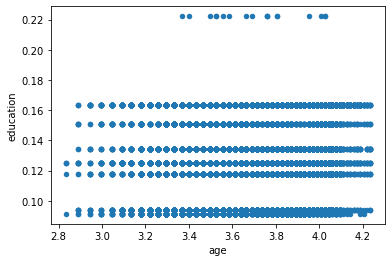

In [67]:
df.plot.scatter('age','education')

In [68]:
# STATISTICAL ANALYSIS BETWEEN NUMERIC ('age') AND CATEGORICAL ('education') ATTRIBUTES IN 'numeric_dataset'
pbr_corr,pValue = pointbiserialr(df.age, df.education)
print('correlation = ',pbr_corr)
a = 0.05
if pValue <= a:
    print('p is ',pValue, '<',a, 'so we reject the null hypothesis and take the alternative hypothesis.')
else:
    print('p is ',pValue,'>',a, 'so we accept the null hypothesis.')

correlation =  0.11025742045604106
p is  8.414463544632235e-93 < 0.05 so we reject the null hypothesis and take the alternative hypothesis.


<AxesSubplot:xlabel='education', ylabel='cons.conf.idx'>

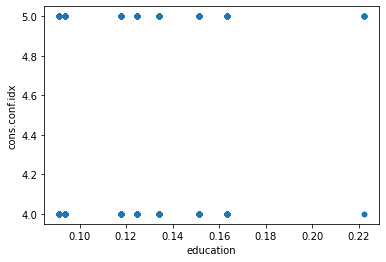

In [69]:
df.plot.scatter('education', 'cons.conf.idx')

In [70]:
# CORRELATION BETWEEN NUMERIC ('cons.conf.idx') AND CATEGORICAL ('education') ATTRIBUTES IN 'numeric_dataset'
pbr_corr,pValue = pointbiserialr(df['cons.conf.idx'], df['education'])
print('correlation = ',pbr_corr)
a= 0.05
if pValue <= a:
    print('p is ',pValue, '<',a, 'so we reject the null hypothesis and take the alternative hypothesis.')
else:
    print('p is ',pValue,'>', a, 'so we accept the null hypothesis.')

correlation =  -0.07547816976547973
p is  2.5376558223943627e-44 < 0.05 so we reject the null hypothesis and take the alternative hypothesis.


<AxesSubplot:xlabel='education', ylabel='marital'>

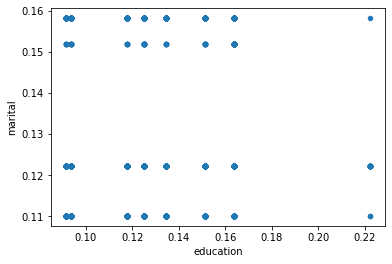

In [71]:
df.plot.scatter('education', 'marital')

In [72]:
# STATISTICAL ANALYSIS BETWEEN CATEGORICAL ('education') AND CATEGORICAL ('marital') ATTRIBUTES IN 'numeric_dataset' 
prbblty_tbl=pd.crosstab(df["education"],df["marital"])
observedValues = prbblty_tbl.values 
b=stats.chi2_contingency(prbblty_tbl)
expectedValues = b[3]
number_rws=len(prbblty_tbl.iloc[0:2,0])
number_clmns=len(prbblty_tbl.iloc[0,0:2])
dgrsOfFrdm=(number_rws-1)*(number_clmns-1)
chiSqaured=sum([(i-j)**2./j for i,j in zip(observedValues,expectedValues)])
chiSquared_stats=chiSqaured[0]+chiSqaured[1]
criticalValue=chi2.ppf(q=1-a,df=dgrsOfFrdm)
pValue=1-chi2.cdf(x=chiSquared_stats,df=dgrsOfFrdm)
print('result of chiSquared =',chiSquared_stats)
print('the criticalValue =',criticalValue)
print('p is',pValue)

if pValue<=a:
    print("Since ",pValue, " <",a, "we reject H0, relationship exst among the 2 attributes")
else:
    print("Since ",pValue, " >",a, "we accept H0, relationship doesnt exist among the 2 attributes")

result of chiSquared = 499.9410084267369
the criticalValue = 3.841458820694124
p is 0.0
Since  0.0  < 0.05 we reject H0, relationship exst among the 2 attributes


<AxesSubplot:xlabel='education', ylabel='loan'>

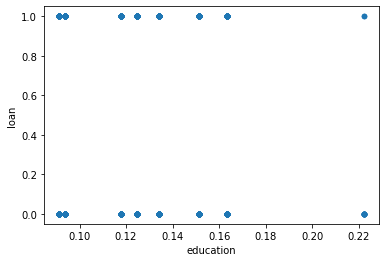

In [73]:
df.plot.scatter('education', 'loan')

In [74]:
# STATISTICAL ANALYSIS BETWEEN CATEGORICAL ('education') AND CATEGORICAL ('loan') ATTRIBUTES IN 'numeric_dataset' 
prbblty_tbl=pd.crosstab(df["education"],df["loan"])
Observed_Values = prbblty_tbl.values 
b=stats.chi2_contingency(prbblty_tbl)
expectedValues = b[3]
number_rws=len(prbblty_tbl.iloc[0:2,0])
number_clmns=len(prbblty_tbl.iloc[0,0:2])
dgrsOfFrdm=(number_rws-1)*(number_clmns-1)
chi_sqrd=sum([(i-j)**2./j for i,j in zip(Observed_Values,expectedValues)])
chi_sqrd_stats=chi_sqrd[0]+chi_sqrd[1]
crtclValue=chi2.ppf(q=1-a,df=dgrsOfFrdm)
pValue=1-chi2.cdf(x=chi_sqrd_stats,df=dgrsOfFrdm)
print('result of chiSquared =',chi_sqrd_stats)
print('the criticalValue =',crtclValue)
print('p is',pValue)

if pValue<=a:
    print("Since ",pValue, " <",a, "we reject H0, relationship exst among the 2 attributes")
else:
    print("Since ",pValue, " >",a, "we accept H0, relationship doesnt exist among the 2 attributes")

result of chiSquared = 21.02197095094491
the criticalValue = 3.841458820694124
p is 4.5404663626680275e-06
Since  4.5404663626680275e-06  < 0.05 we reject H0, relationship exst among the 2 attributes


<AxesSubplot:xlabel='age', ylabel='duration'>

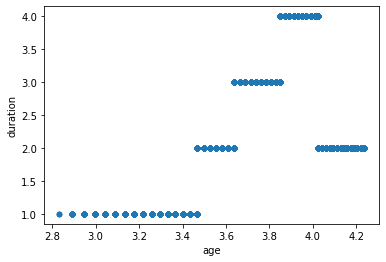

In [75]:
df.plot.scatter('age', 'duration')

In [76]:
# STATISTICAL ANALYSIS BETWEEN NUMERIC ('education') AND NUMERIC ('marital') ATTRIBUTES IN 'numeric_dataset' 
correlation_coffecient = np.corrcoef(df['duration'], df['age'])
print(correlation_coffecient)

[[1.        0.7901309]
 [0.7901309 1.       ]]


In [77]:
z_test ,p_value = stests.ztest(df['duration'], x2=df['age'], value=0, alternative='two-sided')
if p_value<=a:
    print("Since ",p_value, " <", a, "we reject H0, the mean of both attributes are not equal")
else:
    print("Since ",p_value, " >",a, "we accept H0, the mean of both attributes are equal")

Since  0.0  < 0.05 we reject H0, the mean of both attributes are not equal


MACHINE LEARNING IMPLEMENTATION 

In [78]:
# SPLITING THE DATASET FOR TRAINING AND TESTING
random_state = 11
x_Train, x_Test, y_Train, y_Test = train_test_split(numeric_dataset, y, test_size=0.2, random_state=random_state)
gc.collect()

45200

In [79]:
# CHECK THE SHAPE OF THE NEWLY DATASETS
print(x_Train.shape)
print(y_Train.shape)
print(x_Test.shape)
print(y_Test.shape)

(27311, 44)
(27311,)
(6828, 44)
(6828,)


In [80]:
# BUILD PIPELINE OF CLASSIFIERS

n_jobs = -1

pipe_lgstcRgrssn = Pipeline([('lr', LogisticRegression(random_state=random_state, n_jobs=n_jobs, max_iter=500))])

pipe_rndmFrst = Pipeline([('rf', RandomForestClassifier(random_state=random_state, oob_score=True, n_jobs=n_jobs))])

pipe_kNrstNghbr = Pipeline([('knn', KNeighborsClassifier(n_jobs=n_jobs))])

pipe_dcsnTr = Pipeline([('dt', DecisionTreeClassifier(random_state=random_state, max_features='auto'))])

pipe_bg = Pipeline([('bag',BaggingClassifier(base_estimator=SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500),random_state=random_state,oob_score=True,n_jobs=n_jobs))])

pipe_sgd = Pipeline([('sgd', SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500))])

In [81]:
# SET PARAMETERS FOR GRID SEARCH
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=random_state)
grid_params_lgstcRgrssn = [{
                'lr__penalty': ['l2'],
                'lr__C': [0.3, 0.6, 0.7],
                'lr__solver': ['sag']
                }]

grid_params_rndmFrst = [{
                'rf__criterion': ['entropy'],
                'rf__min_samples_leaf': [80, 100],
                'rf__max_depth': [25, 27],
                'rf__min_samples_split': [3, 5],
                'rf__n_estimators' : [60, 70]
                }]
grid_params_kNrstNghbr = [{'knn__n_neighbors': [16,17,18]}]

grid_params_dcsnTr = [{
                'dt__max_depth': [8, 10],
                'dt__min_samples_leaf': [1, 3, 5, 7]
                  }]

grid_params_bg = [{'bag__n_estimators': [10, 15, 20]}]

grid_params_sgd = [{
                    'sgd__loss': ['log', 'huber'],
                    'sgd__learning_rate': ['adaptive'],
                    'sgd__eta0': [0.001, 0.01, 0.1],
                    'sgd__penalty': ['l1', 'l2', 'elasticnet'], 
                    'sgd__alpha':[0.1, 1, 5, 10]
                    }]

In [82]:
# GRID SEARCH OBJECTS 
gridSearch_logisticRegression = GridSearchCV(pipe_lgstcRgrssn, param_grid=grid_params_lgstcRgrssn,scoring='accuracy', cv=cv) 

gridSearch_randomForest = GridSearchCV(pipe_rndmFrst, param_grid=grid_params_rndmFrst,scoring='accuracy', cv=cv)

gridSearch_k_nearestNeighbor = GridSearchCV(pipe_kNrstNghbr, param_grid=grid_params_kNrstNghbr,scoring='accuracy', cv=cv)

gridSearch_decisionTree = GridSearchCV(pipe_dcsnTr, param_grid=grid_params_dcsnTr,scoring='accuracy', cv=cv)

gridSearch_bag = GridSearchCV(pipe_bg, param_grid=grid_params_bg, scoring='accuracy', cv=cv)

gridSearch_sgd = GridSearchCV(pipe_sgd, param_grid=grid_params_sgd,scoring='accuracy', cv=cv)

In [83]:
look_for = [gridSearch_logisticRegression, gridSearch_randomForest , gridSearch_k_nearestNeighbor , gridSearch_decisionTree, gridSearch_bag, gridSearch_sgd]

model_dict = {0:'LogisticRegression', 1:'RandomForest', 2:'K_Nearest_Neighbor', 3:'DecisionTree', 4:'Bag', 5:'SGD'}

In [84]:
result_acc = {}
result_auc = {}
models = []

for index, model in enumerate(look_for):
        start = time.time()
        print()
        print('+++++++ Start New Model ++++++++++')
        print('Estimator is {}'.format(model_dict[index]))
        model.fit(x_Train, y_Train)
        
        print('bst prmtrs {}'.format(model.best_params_))
        print('bst scr is {}'.format(model.best_score_))
        auc = roc_auc_score(y_Test, model.predict_proba(x_Test)[:,1])
        
        print('ROC_AUC is {} and accuracy rate is {}'.format(auc, model.score(x_Test, y_Test)))
        end = time.time()
        print('It lasted for {} sec'.format(round(end - start, 3)))
        print('++++++++ End Model +++++++++++++++++++++++++++')
        print()
        print()
        models.append(model.best_estimator_)
        result_acc[index] = model.best_score_
        result_auc[index] = auc


+++++++ Start New Model ++++++++++
Estimator is LogisticRegression
bst prmtrs {'lr__C': 0.7, 'lr__penalty': 'l2', 'lr__solver': 'sag'}
bst scr is 0.8836732553130467
ROC_AUC is 0.7735971403585877 and accuracy rate is 0.8791739894551845
It lasted for 85.993 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++
Estimator is RandomForest
bst prmtrs {'rf__criterion': 'entropy', 'rf__max_depth': 25, 'rf__min_samples_leaf': 100, 'rf__min_samples_split': 3, 'rf__n_estimators': 60}
bst scr is 0.8840028049285722
ROC_AUC is 0.781642845101628 and accuracy rate is 0.8794669009958992
It lasted for 72.571 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++
Estimator is K_Nearest_Neighbor
bst prmtrs {'knn__n_neighbors': 18}
bst scr is 0.8815861278560281
ROC_AUC is 0.7545360627287834 and accuracy rate is 0.879759812536614
It lasted for 123.564 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++

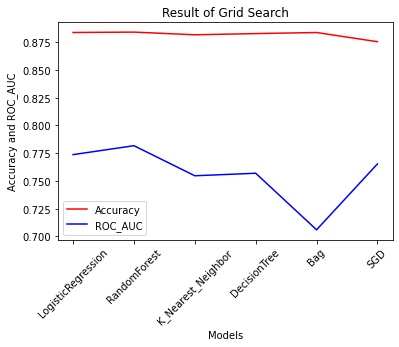

In [85]:
plt.plot(model_dict.values(), result_acc.values(), c='r')
plt.plot(model_dict.values(), result_auc.values(), c='b')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.ylabel('Accuracy and ROC_AUC')
plt.title('Result of Grid Search')
plt.legend(['Accuracy', 'ROC_AUC'])
plt.show()

In [86]:
pd.DataFrame(list(zip(model_dict.values(), result_acc.values(), result_auc.values())), columns=['Model', 'Accuracy_rate','Roc_auc_rate'])

,Model,Accuracy_rate,Roc_auc_rate
0,LogisticRegression,0.883673,0.773597
1,RandomForest,0.884003,0.781643
2,K_Nearest_Neighbor,0.881586,0.754536
3,DecisionTree,0.882685,0.756830
4,Bag,0.883637,0.705861
5,SGD,0.875362,0.765214


100%|██████████| 39/39 [01:19<00:00,  2.03s/it]

max oob 0.8839295521950862 and number of estimators 195


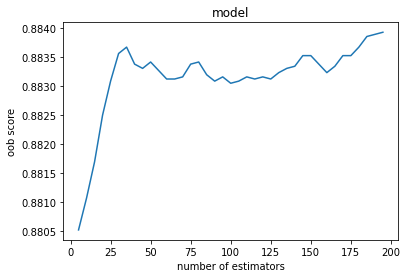

In [87]:
def graph(model, xTrain, yTrain):
    obbList = []
    estmt = list(range(5, 200, 5))
    for i in tqdm(estmt):
        rndmFrst = model(n_estimators=i, criterion='entropy', random_state=11, oob_score=True, n_jobs=-1, max_depth=25, min_samples_leaf=80, min_samples_split=3,)
        rndmFrst.fit(xTrain, yTrain)
        obbList.append(rndmFrst.oob_score_)
    print('max oob {} and number of estimators {}'.format(max(obbList), estmt[np.argmax(obbList)]))
    plt.plot(estmt, obbList)
    plt.title('model')
    plt.xlabel('number of estimators')
    plt.ylabel('oob score')
    plt.show()
    
graph(RandomForestClassifier, x_Train, y_Train)

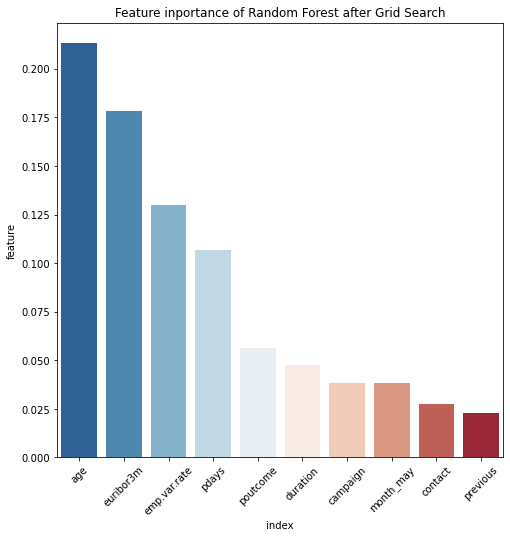

In [88]:
# FEATURES INCLUDED IN THE FINAL MODEL
def build_feature_importance(model, xTrain, yTrain):
    
    models = RandomForestClassifier(criterion='entropy', random_state=11, oob_score=True, n_jobs=-1, max_depth=25, min_samples_leaf=80, min_samples_split=3, n_estimators=70)
    models.fit(xTrain, yTrain)
    data = pd.DataFrame(models.feature_importances_, xTrain.columns, columns=["feature"])
    data = data.sort_values(by='feature', ascending=False).reset_index()
    plt.figure(figsize=[8,8])
    sbrn.barplot(x='index', y='feature', data=data[:10], palette="RdBu_r")
    plt.title('Feature inportance of Random Forest after Grid Search')
    plt.xticks(rotation=45)
    plt.show()
    
build_feature_importance(RandomForestClassifier, x_Train, y_Train)